## GTA V Dataset 

There are 2 main categories of data:
- image data from GPU, stored as images
- non-image metadata from GTA API, stored as json

image data contain:
- RGB image, as JPG, 3x8bit pixel, true color
- depth image, as PNG, 1x16bit unsigned pixel, black and white
- stencil image, as PNG, 1x8bit unsigned pixel, black and white

Note on rotations: 
All rotations are in degrees, and in Euler angles. 
Note on positions:
All positions which are in GTA world coordinates, are most probably in meters.

metadata contain:
- imagepath: base name of image file
    - RGB image is named [imagepath].jpg
    - depth image is named [imagepath]-depth.png
    - stencil image is named [imagepath]-stencil.png
- timestamp: real date and time when snapshot was created, in %Y-%m-%d %H:%M:%S format
- timeofday: internal game time in %H:%M:%S format
- currentweather: weather in game, one value from enum https://github.com/crosire/scripthookvdotnet/blob/master/source/scripting/World.hpp#L202
- width of images
- height of images
- snapshot_id: id of snapshot in database, integer, incremented by 1 each frame,
- camera_rot: camera rotation in degrees, Euler angles
- camera_pos: camera position in GTA world coordinates
- camera_fov: vertical field of view of camera. Horizontal field of view is calculated through width and height ratio
- camera_relative_rotation: rotation of camera relatively to the driver's car, in degrees, Euler angles
- view_matrix: view matrix
- proj_matrix: projection matrix
- entities: list of cars and pedestrians near the car

each entitiy has structure:
- model_sizes
    - size of model, cube, relative to entity center
    - list of floats is as follows: 
        - x min
        - x max
        - y min
        - y max
        - z min
        - z max
    - to obtain 3D bounding box, the cube must be rotated by same angles the entity is rotated
    - because these coordinated are relative to entity center, the min ponits are negative, and the max point are positive
    - probably in meters?
- bbox
    - points of 2D bounding box, in format [[y max, x max], [y min, x min]] 
    - For some (probably most of) entities, the 2D bounding box is [[Infinity,Infinity], [-Infinity,-Infinity]], which means the entity is whole outside of image, or partially out of image
    - 2D bounding box is calculated only for entities which are whole inside the image
    - in range [0, 1], must be multiplied by width or height to get bounding box pixels
- pos
    - position of entity in GTA world coordinates, in [x, y, z]
- rot
    - rotation of entity in degrees, in Euler angles
- class
    - for car, there is car type, one value of enum https://github.com/crosire/scripthookvdotnet/blob/d84bccc5b75ff1bd0530f4d31387ca40586a5b71/source/scripting/World/Entities/Vehicles/Vehicle.cs#L31
    - for pedestrians, it is Unknown
- handle
    - unique identifier of entity in GTA, ID identifying entity through all images
- type
    - one of enum [car, person]

Depth image details:
- depth is originally in NDC (normalized device coordinates), which is in [0, 1] interval where 1 is nearest and 0 is farthest
- because PNG, and all common image formats support only integer values, depth was mapped from range [0, 1] to range [0, 65535], which is range of 16bit unsigned integer. So if you divide each pixel by 65535, you obtain depth in NDC.
- when loading depth, assure you are loading into 16bit integers, and not into 8bit integers

Stencil image details:
- stencil contains pixel-wise metadata. It is 8bit unsigned integer
- so the information for each pixel is in 8 bits
- first 4 bits (part with MSB) contain flags, there are 4 flags contained here
- last 4 bits (part with LSB) represent 4bit integer ID
- this is not completely reverse-engineered so we don't know semantics of all ids and all flags. But from what we know yet:
- last 4 bits, ids:
    - 0 = background object
    - 1 = pedestrian
    - 2 = car
    - 3 = tree
    - 7 = sky
- first 4 bits contain flags of telling if pixel contains current player, if it is illuminated by artificial lightsource, and some other values we don't know
- sometimes there is nothing in the flags, they are all zero

### Visualization pipeline of GTA V

In this section, I'll cover visualization pipeline from GTA world coordinates to image pixels. 

Little terminology note: In computer graphics, projection matrix is not the same projection matrix as in computer vision. In computer graphics, it is still 4x4 matrix.

GTA V does not use OpenGL, nor DirectX, it uses RAGE (Rockstar Advanced Game Engine). 

The pipeline looks very similar to OpenGL, but there are some differences. 

This is OpenGL visualization pipeline, I shall use it to describe the RAGE visualization pipeline:

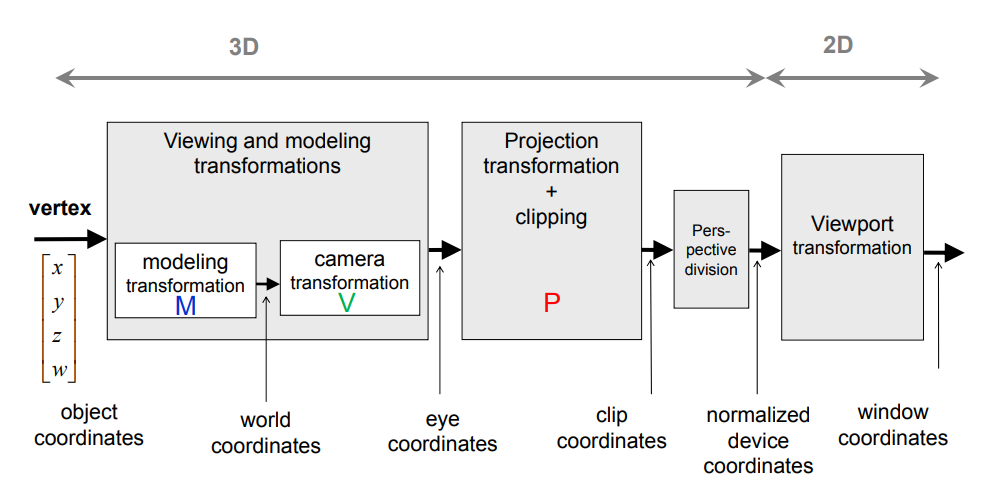

The RAGE pipeline is world coordinates -> (view_matrix) -> camera coordinates -> (projection matrix) -> NDC -> (rescale) -> pixels in image

In GTA, we almost never encounter object coordinates, (except of model_sizes, which are in object coordinates). 
Most of coordinates are world coordinates. 

In computer graphics, we deal with points in homogeneous coordinates, so almost all the time, points are in 4D.

By 
$ 
\begin{pmatrix}
view\_matrix
\end{pmatrix}
\begin{pmatrix}
X_{world\_coords} \\
Y_{world\_coords} \\
Z_{world\_coords} \\
1 \\
\end{pmatrix}
=
\begin{pmatrix}
X_{camera\_coords} \cdot W \\
Y_{camera\_coords} \cdot W \\
Z_{camera\_coords} \cdot W \\
W_{camera\_coords} \\
\end{pmatrix}
$
 we obtain camera coordinates of point from GTA world coordinates of point.
 
Then we normalize the vector, so the last coordinate is 1:
$
\begin{pmatrix}
X_{camera\_coords} \cdot W \\
Y_{camera\_coords} \cdot W \\
Z_{camera\_coords} \cdot W \\
W \\
\end{pmatrix}
/ W
=
\begin{pmatrix}
X_{camera\_coords} \\
Y_{camera\_coords} \\
Z_{camera\_coords} \\
1 \\
\end{pmatrix}
$

The view matrix is rigid body transformation, it does only translation and rotation, it does not deform coordinates, so here are (most probably?) coordinates still in meters.

Then, camera coordinates are transferred to NDC coordinates. In GTA, the projection transformation and clipping is contained in projection matrix. 
In NDC, frustum seen by camera is transformed into cuboid with size:

$ x \in [-1, 1] $,
$ y \in [-1, 1] $,
$ z \in [0, 1] $

So the transformation looks as follows:
$ 
\begin{pmatrix}
projection\_matrix
\end{pmatrix}
\begin{pmatrix}
X_{camera\_coords} \\
Y_{camera\_coords} \\
Z_{camera\_coords} \\
1 \\
\end{pmatrix}
=
\begin{pmatrix}
X_{NDC} \cdot W \\
Y_{NDC} \cdot W \\
Z_{NDC} \cdot W \\
W \\
\end{pmatrix}
$

Again, then we normalize it
$
\begin{pmatrix}
X_{NDC} \cdot W \\
Y_{NDC} \cdot W \\
Z_{NDC} \cdot W \\
W \\
\end{pmatrix}
/ W
=
\begin{pmatrix}
X_{NDC} \\
Y_{NDC} \\
Z_{NDC} \\
1 \\
\end{pmatrix}
$

Then, we have our point in NDC. NDC is important, because depth is in NDC.

Then we map it from NDC into pixels, so from $ x \in [-1, 1] $, $ y \in [-1, 1] $ we rescale to $ x \in [0, width] $, $ y \in [0, height] $

# Example with one dataset sample

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import os
from gta_math import points_to_homo, ndc_to_view, construct_proj_matrix, view_to_world, construct_view_matrix
from PIL import Image
import pickle
import json
from matplotlib import patches
from math import tan, atan, radians, degrees, cos, sin

## loading images

In [133]:
# base_name = '2018-03-30--10-03-30--419'
base_name = '2018-03-30--04-05-57--208'
rgb_file = 'example/{}.jpg'.format(base_name)
json_file = 'example/{}.json'.format(base_name)
depth_file = 'example/{}-depth.png'.format(base_name)
stencil_file = 'example/{}-stencil.png'.format(base_name)

In [134]:
rgb = np.array(Image.open(rgb_file))
depth = np.array(Image.open(depth_file))
depth = depth / np.iinfo(np.uint16).max  # normalizing into NDC
stencil = np.array(Image.open(stencil_file))

### showing images

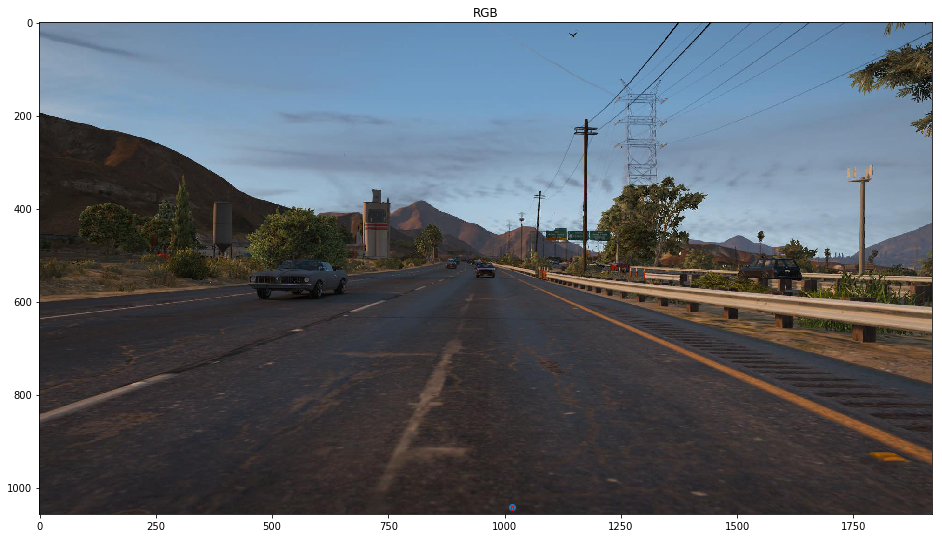

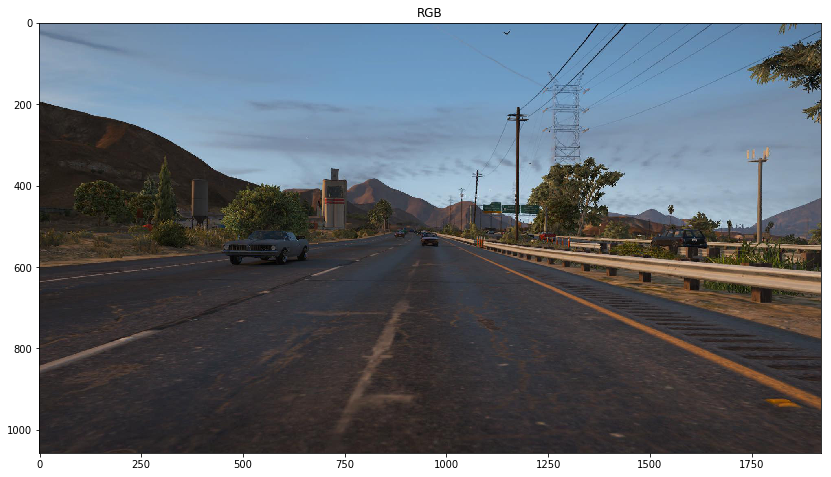

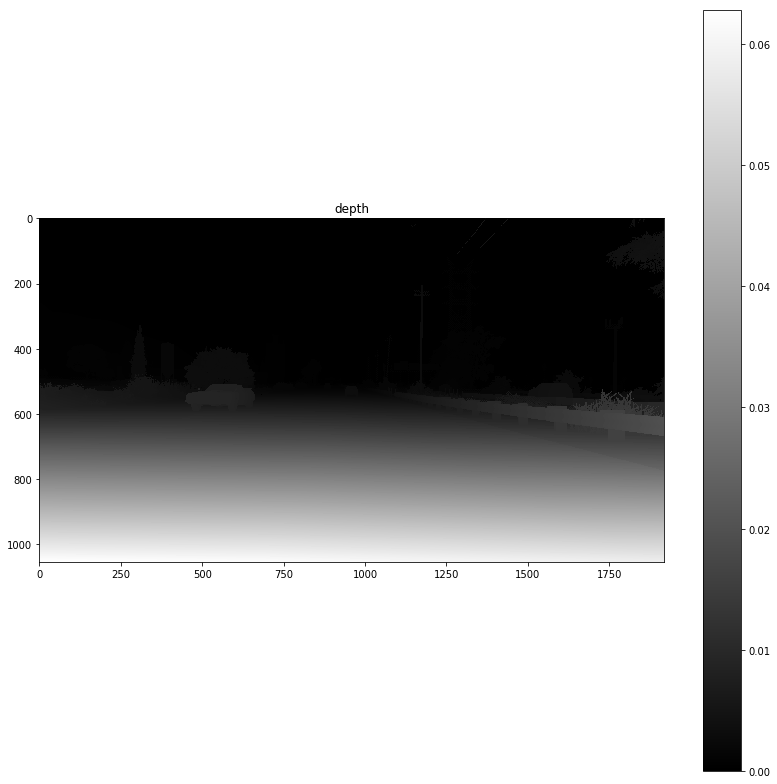

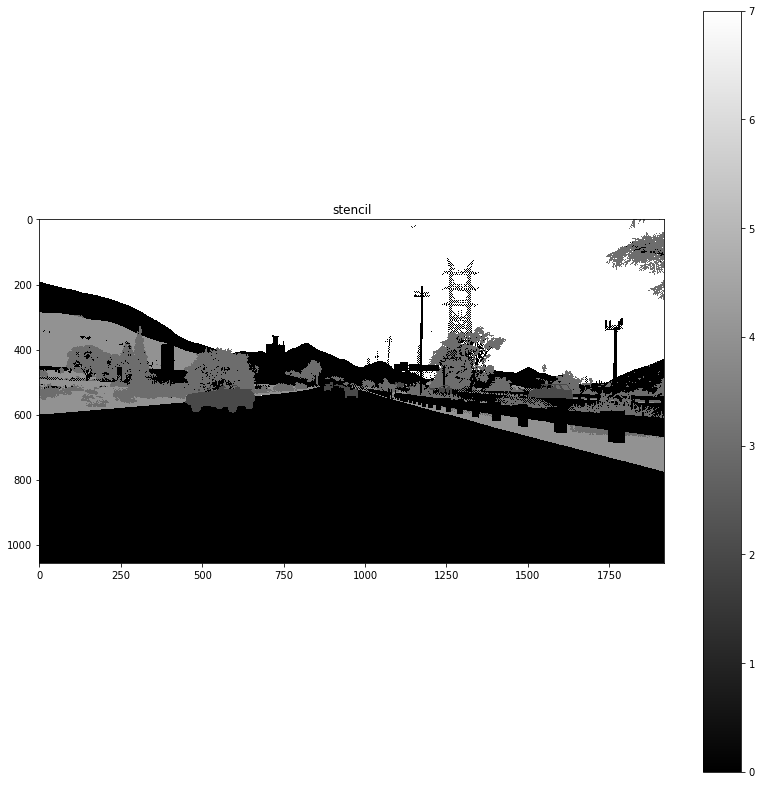

In [135]:
fig = plt.figure(figsize=(14, 14))
plt.title('RGB')
plt.imshow(rgb)

fig = plt.figure(figsize=(14, 14))
plt.title('depth')
ii = plt.imshow(depth, cmap='gray')
plt.colorbar(ii)

fig = plt.figure(figsize=(14, 14))
plt.title('stencil')
ii = plt.imshow(stencil, cmap='gray')
plt.colorbar(ii)

plt.show()

### loading json

In [136]:
with open(json_file, mode='r') as f:
    data = json.load(f)

### showing information from json

In [137]:
imagepath = data['imagepath']
weather = data['currentweather']
width = data['width']
height = data['height']
entities = data['entities']
visible_entities = [e for e in entities if e['bbox'][0] != [np.inf, np.inf]]
view_matrix = np.array(data['view_matrix'])
proj_matrix = np.array(data['proj_matrix'])

print('images base name is: {}'.format(imagepath))
print('weather is: {}'.format(weather))
print('width is: {}'.format(width))
print('height is: {}'.format(height))
print('there are {} entities'.format(len(entities)))
print('{} entities are whole in image'.format(len(visible_entities)))

images base name is: 2018-03-30--04-05-57--208
weather is: Clear
width is: 1920
height is: 1057
there are 67 entities
39 entities are whole in image


### projecting 2D bounding boxes and positions of cars into image

In [138]:
def homo_world_coords_to_pixel(point_homo, view_matrix, proj_matrix, width, height):
    viewed = view_matrix @ point_homo
    projected = proj_matrix @ viewed
    projected /= projected[3]
    to_pixel_matrix = np.array([
        [width/2, 0, 0, width/2],
        [0, -height/2, 0, height/2],
    ])
    in_pixels = to_pixel_matrix @ projected
    return in_pixels


def world_coords_to_pixel(pos, view_matrix, proj_matrix, width, height):
    point_homo = np.array([pos[0], pos[1], pos[2], 1])
    return homo_world_coords_to_pixel(point_homo, view_matrix, proj_matrix, width, height)


def model_coords_to_pixel(model_pos, model_rot, pos, view_matrix, proj_matrix, width, height):
    point_homo = np.array([pos[0], pos[1], pos[2], 1])
    model_matrix = construct_model_matrix(model_pos, model_rot)
    # print('model_matrix\n', model_matrix)
    world_point_homo = model_matrix @ point_homo
    return homo_world_coords_to_pixel(world_point_homo, view_matrix, proj_matrix, width, height)


def create_rot_matrix(euler):
    x = np.radians(euler[0])
    y = np.radians(euler[1])
    z = np.radians(euler[2])

    Rx = np.array([
        [1, 0, 0],
        [0, cos(x), -sin(x)],
        [0, sin(x), cos(x)]
    ], dtype=np.float)
    Ry = np.array([
        [cos(y), 0, sin(y)],
        [0, 1, 0],
        [-sin(y), 0, cos(y)]
    ], dtype=np.float)
    Rz = np.array([
        [cos(z), -sin(z), 0],
        [sin(z), cos(z), 0],
        [0, 0, 1]
    ], dtype=np.float)
    result = Rx @ Ry @ Rz
    return result


def construct_model_matrix(position, rotation):
    view_matrix = np.zeros((4, 4))
    # view_matrix[0:3, 3] = camera_pos
    view_matrix[0:3, 0:3] = create_rot_matrix(rotation)
    view_matrix[0:3, 3] = position
    view_matrix[3, 3] = 1

    return view_matrix


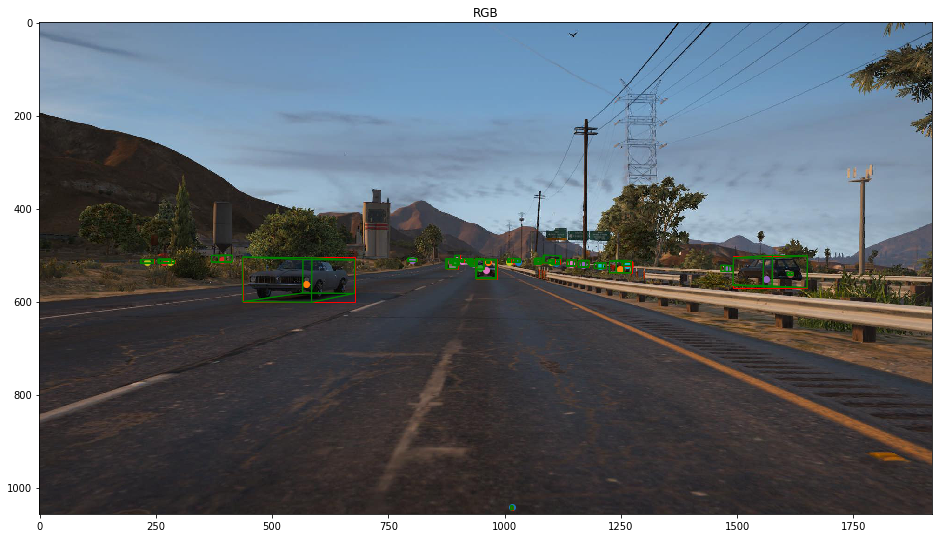

In [139]:
fig = plt.figure(figsize=(16, 16))
plt.title('RGB')
plt.imshow(rgb)

for row in visible_entities:
    # position in world coords
    pos = np.array(row['pos'])
    pixel_pos = world_coords_to_pixel(pos, view_matrix, proj_matrix, width, height)
    plt.scatter(pixel_pos[0], pixel_pos[1])

    # bounding box
    bbox = np.array(row['bbox'])
    bbox[:, 0] *= width
    bbox[:, 1] *= height
    bbox_width, bbox_height = bbox[0, :] - bbox[1, :]
    rect = patches.Rectangle(bbox[1, :], bbox_width, bbox_height, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

    # 3D bounding box
    rot = np.array(row['rot'])
    model_sizes = np.array(row['model_sizes'])
    x_min, x_max, y_min, y_max, z_min, z_max = model_sizes
    # preparing points of cuboid
    points_3dbbox = np.array([
        [x_min, y_min, z_min],
        [x_min, y_min, z_max],
        [x_min, y_max, z_min],
        [x_min, y_max, z_max],
        [x_max, y_min, z_min],
        [x_max, y_min, z_max],
        [x_max, y_max, z_min],
        [x_max, y_max, z_max],
    ])
    # projecting cuboid to 2d
    bbox_2d = np.zeros((8, 2))
    for i, point in enumerate(points_3dbbox):
        # point += pos
        pixel_pos = model_coords_to_pixel(pos, rot, point, view_matrix, proj_matrix, width, height)
        bbox_2d[i, :] = pixel_pos
        # plt.scatter(pixel_pos[0], pixel_pos[1])
        
    # showing cuboid
    pol1 = patches.Polygon(bbox_2d[(0, 1, 3, 2), :], closed=True, linewidth=1, edgecolor='g', facecolor='none')  # fixed x
    pol2 = patches.Polygon(bbox_2d[(4, 5, 7, 6), :], closed=True, linewidth=1, edgecolor='g', facecolor='none')  # fixed x
    pol3 = patches.Polygon(bbox_2d[(0, 2, 6, 4), :], closed=True, linewidth=1, edgecolor='g', facecolor='none')  # fixed z
    pol4 = patches.Polygon(bbox_2d[(1, 3, 7, 5), :], closed=True, linewidth=1, edgecolor='g', facecolor='none')  # fixed z
    pol5 = patches.Polygon(bbox_2d[(0, 1, 5, 4), :], closed=True, linewidth=1, edgecolor='g', facecolor='none')  # fixed y
    pol6 = patches.Polygon(bbox_2d[(2, 3, 7, 6), :], closed=True, linewidth=1, edgecolor='g', facecolor='none')  # fixed y
    plt.gca().add_patch(pol1)
    plt.gca().add_patch(pol2)
    plt.gca().add_patch(pol3)
    plt.gca().add_patch(pol4)
    plt.gca().add_patch(pol5)
    plt.gca().add_patch(pol6)

plt.show()